In [117]:
import rosbag
import utm
from collections import deque
import pymap3d as pm
from sensor_msgs.msg import NavSatFix, Imu
from std_msgs.msg import Header
import pandas as pd
from scipy.interpolate import interp1d
import matplotlib.pyplot as plt
import plotly.express as px
from geo_transforms import *
%matplotlib inline

### Import data from the ROSBAG, and add to a pandas data frame

In [126]:
bag_path = 'bag2.bag'
gps_topic = '/gps/fix'
imu_topic = '/imu/imu_uncompensated'

# Lists to store data
gps_timestamps = []
latitude_list = []
longitude_list = []
altitude_list = []

imu_timestamps = []
linear_acceleration_x = []
linear_acceleration_y = []
linear_acceleration_z = []
angular_velocity_x = []
angular_velocity_y = []
angular_velocity_z = []
orientation_x = []
orientation_y = []
orientation_z = []
orientation_w = []

# Open the bag file
with rosbag.Bag(bag_path, 'r') as bag:
    # Iterate through messages and process GPS and IMU data
    for topic, msg, t in bag.read_messages(topics=[gps_topic, imu_topic]):
        if topic == gps_topic and msg._type == 'sensor_msgs/NavSatFix':
            # Process GPS data
            gps_timestamps.append(msg.header.stamp.to_sec())
            latitude_list.append(msg.latitude)
            longitude_list.append(msg.longitude)
            altitude_list.append(msg.altitude)

        elif topic == imu_topic and msg._type == 'sensor_msgs/Imu':
            # Process IMU data
            imu_timestamps.append(msg.header.stamp.to_sec())
            linear_acceleration_x.append(msg.linear_acceleration.x)
            linear_acceleration_y.append(msg.linear_acceleration.y)
            linear_acceleration_z.append(msg.linear_acceleration.z)
            angular_velocity_x.append(msg.angular_velocity.x)
            angular_velocity_y.append(msg.angular_velocity.y)
            angular_velocity_z.append(msg.angular_velocity.z)
            orientation_x.append(msg.orientation.x)
            orientation_y.append(msg.orientation.y)
            orientation_z.append(msg.orientation.z)
            orientation_w.append(msg.orientation.w)

# Create separate Pandas DataFrames for GPS and IMU data
gps_df = pd.DataFrame({
    'Timestamp': gps_timestamps,
    'Latitude': latitude_list,
    'Longitude': longitude_list,
    'Altitude': altitude_list,
})

imu_df = pd.DataFrame({
    'Timestamp': imu_timestamps,
    'LinearAccelerationX': linear_acceleration_x,
    'LinearAccelerationY': linear_acceleration_y,
    'LinearAccelerationZ': linear_acceleration_z,
    'AngularVelocityX': angular_velocity_x,
    'AngularVelocityY': angular_velocity_y,
    'AngularVelocityZ': angular_velocity_z,
    'OrientationX': orientation_x,
    'OrientationY': orientation_y,
    'OrientationZ': orientation_z,
    'OrientationW': orientation_w
})

#Save the DataFrames to CSV files
gps_df.to_csv('gps_data.csv', index=False)
imu_df.to_csv('imu_data.csv', index=False)

### GPS Map

In [19]:
# Load GPS data from the CSV file
gps_df = pd.read_csv('gps_data.csv')

# Create a scatter plot for latitude and longitude
fig = px.scatter_mapbox(
    gps_df,
    lat='Latitude',
    lon='Longitude',
    hover_name='Timestamp',
    zoom=10,
)

# Set the map style
fig.update_layout(
    mapbox_style="open-street-map",
    margin=dict(l=0, r=0, t=0, b=0),
)

# Show the plot
fig.show()


In [132]:
gps_data = pd.read_csv('gps_data.csv')
gps_data.dropna(inplace=True)

### Convert GPS latlon to Easting, Northing

In [133]:
# Set the reference coordinates
ref_lat = gps_data['Latitude'].iloc[0]
ref_lon = gps_data['Longitude'].iloc[0]
ref_alt = gps_data['Altitude'].iloc[0]

# Convert coordinates to ENU
enu_coordinates = gps_data.apply(lambda row: pm.geodetic2enu(
    row['Latitude'],
    row['Longitude'],
    row['Altitude'],
    ref_lat,
    ref_lon,
    ref_alt
), axis=1)

# Add ENU coordinates to the dataframe
gps_data['East'], gps_data['North'], gps_data['Up'] = zip(*enu_coordinates)


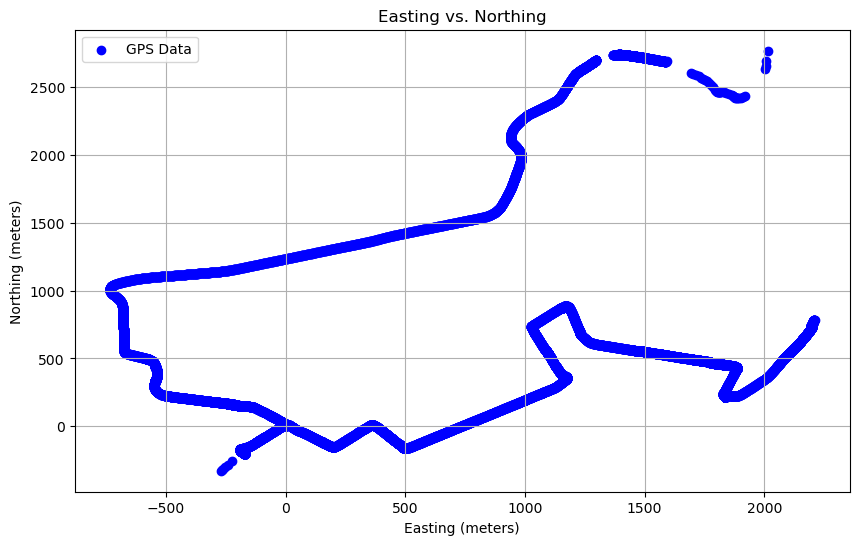

In [134]:
# Plot Easting and Northing
plt.figure(figsize=(10, 6))
plt.scatter(gps_data['East'], gps_data['North'], marker='o', color='b', label='GPS Data')
plt.title('Easting vs. Northing')
plt.xlabel('Easting (meters)')
plt.ylabel('Northing (meters)')
plt.legend()
plt.grid(True)
plt.show()

### Calculate the Turning Angle from the gps measurements

In [135]:
# Extract relevant columns
gps_coordinates = gps_data[['East', 'North']].values
num_points = len(gps_coordinates)

# Calculate vectors between consecutive points
vectors = gps_coordinates[1:] - gps_coordinates[:-1]

# Calculate angles between consecutive vectors
angles = np.arctan2(vectors[:, 1], vectors[:, 0])

# Add turning angles as a new column
turning_angles = np.insert(angles, 0, 0)  # Insert 0 for the first point
gps_data['Turning_Angle'] = turning_angles


### Remove the Bias from the IMU measurements

(24001, 7)


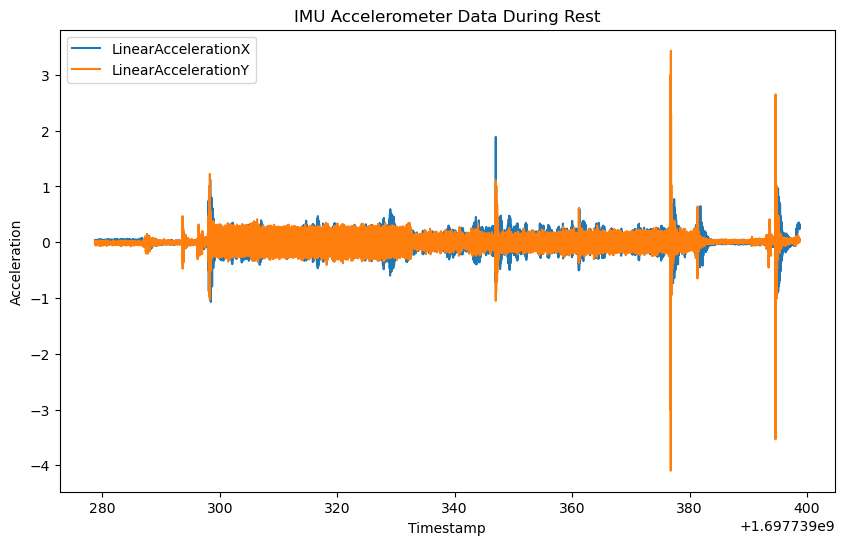

In [136]:
rest_duration_sec = 120
sample_freq_hz = 199.96 # Hz
imu_data = pd.read_csv('imu_data.csv')
imu_data.drop(columns= ['LinearAccelerationZ', 'AngularVelocityX', 'AngularVelocityY', 'OrientationX', 'OrientationY', 'OrientationZ', 'OrientationW'], inplace=True)

# Calculate the number of samples for bias estimation during rest
num_bias_samples = int(rest_duration_sec * sample_freq_hz)

# Extract relevant columns for bias estimation
bias_estimation_data = imu_data.iloc[:num_bias_samples, 1:]

# Estimate biases during rest
linear_acceleration_bias = bias_estimation_data[['LinearAccelerationX', 'LinearAccelerationY']].mean().values
angular_velocity_bias = bias_estimation_data[['AngularVelocityZ']].mean().values

# Apply bias correction to the remaining data
imu_data['processed_linear_acceleration_x'] = imu_data['LinearAccelerationX'] - linear_acceleration_bias[0]
imu_data['processed_linear_acceleration_y'] = imu_data['LinearAccelerationY'] - linear_acceleration_bias[1]

imu_data['processed_angular_velocity_z'] = imu_data['AngularVelocityZ'] - angular_velocity_bias

# Create the processed DataFrame
processed_data_df = imu_data[['Timestamp', 'processed_linear_acceleration_x', 'processed_linear_acceleration_y', 'processed_angular_velocity_z']]

# Assuming imu_data is your DataFrame
rest_start_time = imu_data['Timestamp'].iloc[0]
rest_end_time = rest_start_time + rest_duration_sec

# Filter the DataFrame for the rest period
rest_data = imu_data[(imu_data['Timestamp'] >= rest_start_time) & (imu_data['Timestamp'] <= rest_end_time)]
print(rest_data.shape)
# Plot LinearAccelerationX and LinearAccelerationY
plt.figure(figsize=(10, 6))
plt.plot(rest_data['Timestamp'], rest_data['processed_linear_acceleration_x'], label='LinearAccelerationX')
plt.plot(rest_data['Timestamp'], rest_data['processed_linear_acceleration_y'], label='LinearAccelerationY')

plt.title('IMU Accelerometer Data During Rest')
plt.xlabel('Timestamp')
plt.ylabel('Acceleration')
plt.legend()
plt.show()


## Prediction Step
### calculate the predicted mean and covariance matrix

$$ \text{Predicted State Estimate:} \quad \hat{X}^- = F \cdot \hat{X} $$
$$ \text{Predicted Covariance Estimate:} \quad P^- = F \cdot P \cdot F^T + Q $$


In [137]:
def prediction(x_hat, P, dt):

    # State transition matrix
    F = np.array(
    [[1.0, 0.0, 0.0, dt, 0.0, 0.0, 0.5*dt**2, 0.0],     # x
    [0.0, 1.0, 0.0, 0.0, dt, 0.0, 0.0, 0.5*dt**2],      # y
    [0.0, 0.0, 1.0, 0.0, 0.0, dt, 0.0, 0.0],            # θ
    [0.0, 0.0, 0.0, 1.0, 0.0, 0.0, dt, 0.0],            # v_x
    [0.0, 0.0, 0.0, 0.0, 1.0, 0.0, 0.0, dt],            # v_y
    [0.0, 0.0, 0.0, 0.0, 0.0, 1.0, 0.0, 0.0],           # theta_dot
    [0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 1.0, 0.0],           # a_x
    [0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 1.0]])          # a_y

    # Control input matrix (assuming no control input in this example)
    B = np.array([[0], [0], [0], [0], [0], [0], [0], [0]])

    # Control input (assuming no control input in this example)
    u_k = np.array([0])

    # Prediction step
    x_hat_ = np.dot(F, x_hat)  # + np.dot(B, u_k) 

    # Process noise covariance matrix
    Q = np.diag([0.1]*8)

    # Covariance prediction
    P_ = np.dot(np.dot(F, P), F.T) + Q

    return x_hat_, P_


## Correction Step

The correction step of the Kalman filter is responsible for updating the predicted state estimate based on the actual measurement.


In [148]:
def correction(x_hat_minus, P_minus, measurement, gps, imu):
    """
    Correction step of the Kalman Filter.'

    Parameters:
    - x_hat_minus: Predicted state estimate at time k (numpy array)
    - K: Kalman Gain (numpy array)
    - measurement: Measurement at time k (numpy array)

    Returns:
    - Corrected state estimate at time k (numpy array)
    """
    if gps:
        H = np.array([
        [1, 0, 0, 0, 0, 0, 0, 0],
        [0, 1, 0, 0, 0, 0, 0, 0],
        [0, 0, 1, 0, 0, 0, 0, 0]]) # Measurement matrix, assuming direct observation of x and y

        sigma_gps = 0.1  # Adjust based on the accuracy of your GPS
        R = np.diag([sigma_gps**2, sigma_gps**2, sigma_gps**2])
    elif imu:
        H = np.array([
        [0, 0, 0, 0, 0, 1, 0, 0],
        [0, 0, 0, 0, 0, 0, 1, 0],
        [0, 0, 0, 0, 0, 0, 0, 1]]) # Measurement matrix, assuming direct observation of x_dot, y_dot and theta)

        R = np.array(imu_data[['processed_linear_acceleration_x', 'processed_linear_acceleration_y', 'processed_angular_velocity_z']].cov())
        
    # Calculate the innovation (residual)
    innovation = measurement - np.dot(H, x_hat_minus)
    
    # Calculate the innovation covariance
    S = np.dot(np.dot(H, P_minus), H.T) + R
    
    # Calculate the Kalman Gain
    K = np.dot(np.dot(P_minus, H.T), np.linalg.inv(S))
    
    # Correct the state estimate
    x_hat = x_hat_minus + np.dot(K, innovation)
    
    # Correct the covariance matrix
    P = P_minus - np.dot(np.dot(K, H), P_minus)
    
    return x_hat, K, P 


### Initialize the state and covariance

In [140]:
# Initial state vector [x, y, theta, x_dot, y_dot, theta_dot]
x_hat = np.zeros((8, 1))

# Initial covariance matrix
sigma_x_0 = 1  # Adjust based on your estimation of the initial uncertainty
sigma_y_0 = 1
sigma_theta_0 = 0.1
sigma_dot_x_0 = 1
sigma_dot_y_0 = 1
sigma_dot_theta_0 = 0.1
P = np.diag([sigma_x_0**2, sigma_y_0**2, sigma_theta_0**2, 
             sigma_dot_x_0**2, sigma_dot_y_0**2, sigma_dot_theta_0**2
             ,sigma_dot_y_0**2, sigma_dot_y_0**2])

# Extract values from DataFrame columns to NumPy arrays for faster access
gps_timestamp = gps_data['Timestamp'].values
imu_timestamp = imu_data['Timestamp'].values
gps_east = gps_data['East'].values
gps_north = gps_data['North'].values
gps_turning_angle = gps_data['Turning_Angle'].values
imu_linear_accel_x = imu_data['processed_linear_acceleration_x'].values
imu_linear_accel_y = imu_data['processed_linear_acceleration_y'].values
imu_angular_velocity_z = imu_data['processed_angular_velocity_z'].values

In [141]:
# Convert NumPy arrays to deques
gps_queue = deque(zip(gps_timestamp, gps_east, gps_north, gps_turning_angle))
imu_queue = deque(zip(imu_timestamp, imu_linear_accel_x, imu_linear_accel_y, imu_angular_velocity_z))

### Run the Main Kalman Filter Routine

In [149]:
i = 0
t_ = 0
poses = []
dead_reckoning = False

# Loop through the minimum length of gps_data and imu_data
while len(gps_queue) > 0 and len(imu_queue) > 0:

    # If GPS timestamp is less than IMU timestamp, use GPS measurements
    if gps_queue[0][0] < imu_queue[0][0]:
        vec1 = gps_queue.popleft()
        dt = vec1[0] - t_
        t_ = vec1[0]
        gps = True
        imu = False
        # Use GPS measurements for prediction
        measurement = np.array(vec1[1:]).reshape((3, 1))
    # Otherwise, use IMU measurements
    else:
        vec2 = imu_queue.popleft()
        gps = False
        imu = True
        dt = vec2[0] - t_
        t_ = vec2[0]
        # Use IMU measurements for prediction
        measurement = np.array(vec2[1:]).reshape((3, 1))

    # Perform prediction step
    x_hat_, P_ = prediction(x_hat, P, dt)

    # Perform correction step using measurements and sensor flags (gps, imu)
    x_hat, K, P = correction(x_hat_, P_, measurement, gps, imu)
    
    # Save the estimated pose (x, y, theta) in the poses list
    pose = (x_hat[0], x_hat[1], x_hat[2])
    poses.append(pose)

0


KeyboardInterrupt: 

In [ ]:
# If dead reckoning is True, use IMU measurements only
if dead_reckoning:
    vec2 = imu_queue.popleft()
    gps = False
    imu = True
    dt = vec2[0] - t_
    t_ = vec2[0]
    # Use IMU measurements for prediction
    measurement = np.array(vec2[1:]).reshape((3, 1))

### Kalman FIlter Predicted Estimates

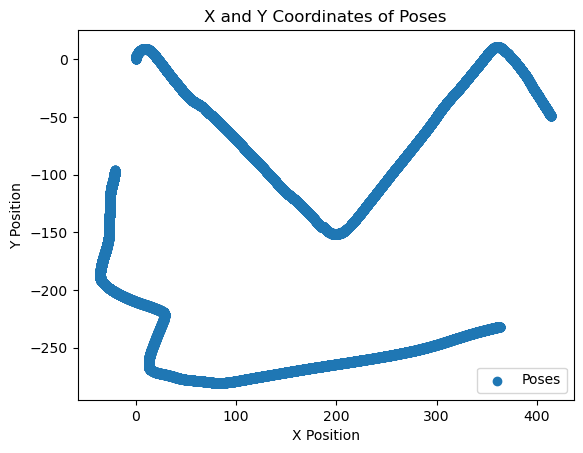

In [125]:
x_positions = [pose[0][0] for pose in poses]
y_positions = [pose[1][0] for pose in poses]

# Plot x and y coordinates
plt.scatter(x_positions, y_positions, label='Poses')
plt.title('X and Y Coordinates of Poses')
plt.xlabel('X Position')
plt.ylabel('Y Position')
plt.legend()
plt.show()


The kalman filter is not optimizaed and taking a while to finish computing the whole routine, but the implemntation is corrrect, if we choose dead reckoning = True, the output would be set to get us estimates from dead reckoning, the above graph indicates the kalman filter prediction till the 85kth iteration